# Прогноз оттока клиентов

## Введение

### Цель проекта

В проекте мы должны разработать модель прогнозирования оттока клиентов оператора связи на основе персональных данных клиентов, информациии об их тарифах и договорах. 

Критерием оценки качества модели должна быть метрика ROC-AUC. Значение метрики должно быть не менее 0.78.

### Основные этапы

### Выводы

## Описание 

### Описание услуг

Оператор предоставляет два основных типа услуг: 
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию DSL (от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные хранятся в таблицах в базе данных PostgreSQL:
1. `contract` — информация о договоре,
1. `personal` — персональные данные клиента,
1. `internet` — информация об интернет-услугах,
1. `phone` — информация об услугах телефонии.

Таблица `telecom.contract`
1. `customerID` — ID пользователя,
1. `BeginDate` — дата начала действия,
1. `EndDate` — дата окончания действия,
1. `Type` — тип оплаты (раз в год или помесячно),
1. `PaperlessBilling` — безбумажный расчётный лист,
1. `PaymentMethod` — тип платежа,
1. `MonthlyCharges` — расход за месяц,
1. `TotalCharges` — общие расходы.

Таблица `personal`
1. `customerID` — ID пользователя,
1. `gender` — пол,
1. `SeniorCitizen` — является ли абонент пенсионером,
1. `Partner` — есть ли у абонента супруг/супруга,
1. `Dependents` — есть ли у абонента дети.

Таблица `telecom.internet`
1. `customerID` — ID пользователя,
1. `InternetService` — тип подключения,
1. `OnlineSecurity` — блокировка небезопасных сайтов,
1. `OnlineBackup` — облачное хранилище файлов для резервного копирования данных,
1. `DeviceProtection` — антивирус,
1. `TechSupport` — выделенная линия технической поддержки,
1. `StreamingTV` — стриминговое телевидение,
1. `StreamingMovies` — каталог фильмов.

Таблица telecom.phone
1. `customerID` — ID пользователя,
1. `MultipleLines` — подключение телефонного аппарата к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020.

## Подготовка кода

### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text

from dotenv import load_dotenv
from os import getenv

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score

### Константы

In [4]:
load_dotenv()
DB_CONFIG = {k : getenv(f"DB_{k.upper()}") for k in ['user','pwd','host','port','db']}

In [5]:
RANDOM_SEED = 20230311

### Функции

In [6]:
class DataSource:
    """Provides database information  
    
    Stores info in self._table as dictionary:
    - table_name:
        - rows_number: int
        - fields:
            - field_name: 
                - uniques: int
                - nans: int
                - type: str
             - ...
    - ...
               
    """
    def __init__(self, user: str, pwd: str, host: str, port: int,
                 db: str, schema: str = "public") -> None:
        """Creates DataSource instance and initialized connection to the source"""

        self.schema = schema
        self._tables = dict()
        _connection_url = f"postgresql://{user}:{pwd}@{host}:{port}/{db}"
        self._engine = create_engine(_connection_url)

        # initialize database tables info
        with self._engine.connect() as connection:        
            self._init_tables_list(connection)
            self._init_tables_info(connection)

        
    def _init_tables_list(self, connection) -> None:
        """Get table list from database schema"""

        _query = f"""
            SELECT table_name
              FROM information_schema.tables
             WHERE table_schema='{self.schema}'
               AND table_type='BASE TABLE';        
        """
        
        for row in connection.execute(_query):
                self._tables[row["table_name"]] = {
                    "fields": {},
                    "rows_number": None
                }

    def _init_table_rows_number(self, table_name: str, connection) -> None:
        """Counts number of rows in table_name"""

        _query = f"""
            SELECT COUNT(*) as rows_number
            FROM {self.schema}.{table_name}
        """
        result = connection.execute(_query)
        self._tables[table_name]["rows_number"] = [
            _ for row in result for _ in row
        ][0]

            
    def _init_table_fields_info(self, table_name: str, connection) -> None:
        """Get tables fields from database schema"""

        _query = f"""
            SELECT column_name, data_type 
            FROM information_schema.columns 
            WHERE table_name='{table_name}'        
        """
        
        for row in connection.execute(_query):
            self._tables[table_name]["fields"][row["column_name"]] = {
                "type": row["data_type"],
                "uniques": 0,
                "nans": 0
            }

    def _init_table_uniques(self, table_name: str, connection) -> None:
        """Counts unique values in table_name fields"""

        _query = "SELECT {} FROM {}".format(
            ", ".join([
                f'COUNT(DISTINCT "{_}") as unique_{_.lower()}'
                for _ in self._tables[table_name]["fields"].keys()
            ]), f"{self.schema}.{table_name}")

        for row in connection.execute(_query):
            for field in self._tables[table_name]["fields"].keys():
                row_key = f"unique_{field.lower()}"
                self._tables[table_name]["fields"][field]["uniques"] = row[
                    row_key.lower()]

    def _init_table_nans(self, table_name: str, connection) -> None:
        """Counts number of NULL values in table_name fields"""
        
        for field in self._tables[table_name]["fields"].keys():
            _query = f"""
                SELECT COUNT(*) 
                FROM {self.schema}.{table_name} 
                WHERE "{field}" IS NULL        
            """
            result = connection.execute(_query)
            self._tables[table_name]["fields"][field]["nans"] = [
                _ for row in result for _ in row
            ][0]
        

    def _init_tables_info(self, connection) -> None:
        """Get tables info from database schema"""

        for table_name in self.tables:
            print(f"Get info for {table_name}")
            print("... rows number")
            self._init_table_rows_number(table_name, connection)
            print("... fields info")
            self._init_table_fields_info(table_name, connection)
            print("... number of unique values")
            self._init_table_uniques(table_name, connection)
            print("... number of nan values")
            self._init_table_nans(table_name, connection)
            print("done")

    @property
    def tables(self) -> list:
        """Returns list of tables in the database"""
        return [*self._tables]

    def exec_query(self, query: str) -> pd.DataFrame:
        """Executes SQL query and return DataFrame"""
        return pd.read_sql_query(query, con=self._engine)

    def table_head(self, table_name: str, number: int = 5) -> pd.DataFrame:
        """Returns first number of records in table_name"""
        return self.exec_query(f"SELECT * FROM {self.schema}.{table_name} LIMIT {number}")

    def table_info(self, table_name: str) -> None:
        """Prints table info"""

        max_field_len = max(
            [len(_) for _ in self._tables[table_name]["fields"].keys()])

        max_type_len = max([
            len(self._tables[table_name]["fields"][field]["type"])
            for field in self._tables[table_name]["fields"].keys()
        ])

        rows_title = f"Field{' '*(max_field_len - len('Field'))}" + \
            "     Uniques     NaNs" + \
            "  Type" + (" "  * (max_type_len - len("Type")))
        print(f"Table: {table_name}")
        print(f"{self._tables[table_name]['rows_number']:,d} rows")
        print("-" * len(rows_title))
        print(rows_title)
        print("-" * len(rows_title))

        for k, v in self._tables[table_name]["fields"].items():
            print(f"{k}{' '*(max_field_len - len(k))}  " +
                  f"{v['uniques']:10,d} {v['nans']:8,d}  {v['type']}")
        print()

## Анализ данных на входе

Создадим объект класса DataSource для получения метаданных о датасете.

In [7]:
ds = DataSource(**DB_CONFIG, schema="telecom")

Get info for contract
... rows number
... fields info
... number of unique values
... number of nan values
done
Get info for internet
... rows number
... fields info
... number of unique values
... number of nan values
done
Get info for personal
... rows number
... fields info
... number of unique values
... number of nan values
done
Get info for phone
... rows number
... fields info
... number of unique values
... number of nan values
done


In [8]:
for table_name in ds.tables:
    ds.table_info(table_name)

Table: contract
7,043 rows
----------------------------------------------
Field                Uniques     NaNs  Type   
----------------------------------------------
customerID             7,043        0  text
BeginDate                515        0  date
EndDate                    4    5,174  date
Type                       3        0  text
PaperlessBilling           2        0  text
PaymentMethod              4        0  text
MonthlyCharges         1,585        0  numeric
TotalCharges           6,530       11  numeric

Table: internet
5,518 rows
--------------------------------
Field     Uniques     NaNs  Type
--------------------------------
c1       5,518        0  text
c2           3        0  text
c3           3        0  text
c4           3        0  text
c5           3        0  text
c6           3        0  text
c7           3        0  text
c8           3        0  text

Table: personal
7,043 rows
-------------------------------------------
Field             Uniques     NaNs 

Количество таблиц и количество полей данных в них соответствует описанию. 

Названия столбцов в таблицах internet и phone не соответсвуют описанию и представлены номерами колонок.

В таблицах `contract` и `personal` 7043 строки, столько же уникальных значений столбца `customerID`. 

Стобец `EndDate` таблицы `contract` содержит 5174 пропуска -- это количество действующих контрактов.

Явные пропуски есть только в столбце `TotalCharges` таблицы `contract`, их всего 11.

Количество строк в таблицах `internet` `phone` равно количеству уникальных значений `customerID`, значит связи 1:1.

Посмотрим на примеры данных.

In [9]:
for table_name in ds.tables:
    _sample = ds.table_head(table_name, 10)
    print(table_name)
    display(_sample)
    print()

contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN



internet


,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No
6,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
7,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
8,6713-OKOMC,DSL,Yes,No,No,No,No,No
9,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes



personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes



phone


,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes
6,7892-POOKP,Yes
7,6388-TABGU,No
8,9763-GRSKD,No
9,7469-LKBCI,No


Пропуски в столбце `TotalCharges` таблицы `contract` видим для контарктов, дата начала которых равна последнему месяцу сбора данных. Предположим, что пропуск говорит о том, что эта сумма не рассчитана из-за короткого срока действия контракта. Пропуски можно заполнить значением `MonthlyCharges`.

Названия столбцов таблиц `internet` и `phone` видим в первой строке данных.

Других аномалий не наблюдаем.

### Вывод

- Все таблицы имеют набор данных.
- Количество таблиц соответствет условию задачи.
- Имеется общий ключ для связи таблиц.
- Названия столбцов таблиц internet и phone видим в первой строке данных.
- Явные пропуски есть только в `EndDate` таблицы `contract` -- говорит о действующем контакте, и  `TotalCharges` таблицы `contract` -- говорит, что контракт только заключен.


## Загрузка данных

Датасет содержит около 10 тыс записей. Связи между таблицами 1:1. Это небольшой объем, будет удобно загрузить все данные одной таблицей в датафрейм пандас.

In [10]:
query = """
SELECT 
    c."customerID"  AS customer_id,
    c."BeginDate" AS begin_date,
    c."EndDate" AS end_date,
    c."Type" AS contract_type,
    c."PaperlessBilling"  AS is_paperless_billing,
    c."PaymentMethod" AS payment_method,
    c."MonthlyCharges" AS monthly_charges,
    c."TotalCharges" AS total_charges,
    p.gender AS customer_gender,
    p."SeniorCitizen" AS is_customer_senior,
    p."Partner" AS has_partner,
    p."Dependents" AS has_dependents,
    phone.c2 AS has_multiple_lines_phone,
    i.c2 AS internet_type,
    i.c3 AS has_online_security,
    i.c4 AS has_online_backup,
    i.c5 AS has_device_protection,
    i.c6 AS has_tech_support,
    i.c7 AS has_streaming_tv,
    i.c8 AS has_streaming_movies
FROM telecom.contract c 
LEFT JOIN telecom.personal p ON c."customerID" = p."customerID" 
LEFT JOIN telecom.phone phone ON c."customerID" = phone.c1
LEFT JOIN telecom.internet i ON c."customerID" = i.c1 ;
"""

df = ds.exec_query(query)
df.shape

(7043, 20)

7043 контактов и информация, связанная с ними, поулчены.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               7043 non-null   object 
 1   begin_date                7043 non-null   object 
 2   end_date                  1869 non-null   object 
 3   contract_type             7043 non-null   object 
 4   is_paperless_billing      7043 non-null   object 
 5   payment_method            7043 non-null   object 
 6   monthly_charges           7043 non-null   float64
 7   total_charges             7032 non-null   float64
 8   customer_gender           7043 non-null   object 
 9   is_customer_senior        7043 non-null   int64  
 10  has_partner               7043 non-null   object 
 11  has_dependents            7043 non-null   object 
 12  has_multiple_lines_phone  6361 non-null   object 
 13  internet_type             5517 non-null   object 
 14  has_onli

Все данные из `internet` и `phone`, кроме первой строки с названиями колонок, на месте.

In [12]:
df.head().T

,0,1,2,3,4
customer_id,4472-LVYGI,3115-CZMZD,3668-QPYBK,5709-LVOEQ,9237-HQITU
begin_date,2020-02-01,2020-02-01,2018-08-09,2020-02-01,2019-01-26
end_date,None,None,2019-12-01,None,2019-11-01
contract_type,Two year,Two year,Month-to-month,Two year,Month-to-month
is_paperless_billing,Yes,No,Yes,No,Yes
payment_method,Bank transfer (automatic),Mailed check,Mailed check,Mailed check,Electronic check
monthly_charges,52.55,20.25,53.85,80.85,70.7
total_charges,NaN,NaN,108.15,NaN,151.65
customer_gender,Female,Male,Male,Female,Female
is_customer_senior,0,0,0,0,0


Датасет готов.

## Создание признаков

Добавим целевой признак `is_lost_customer`, равный 0 для клиентов с пропуском в `end_date` и 1 в противном случае.

In [13]:
df["is_lost_customer"] = (~df["end_date"].isna()).astype(int)

Преобразуем тип для дат из строк в date

In [14]:
df.begin_date = pd.to_datetime(df.begin_date, format="%Y-%m-%d").dt.floor("D")

In [15]:
df.end_date = pd.to_datetime(df.end_date, format="%Y-%m-%d").dt.floor("D")

Заполним пропуски в end_date максимальным значением begin_date и посчитаем возраст контракта в днях.

In [16]:
df.end_date = df.end_date.fillna(df.begin_date.max())

In [17]:
df["contract_age_days"] = (df.end_date - df.begin_date).dt.days

Заполним пропуски в `total_charges` значениями из `monthly_charges`.

In [18]:
df.total_charges = df.total_charges.fillna(df.monthly_charges)

Добавим признаки, пользуется ли клиент услугами телефонии и интернета.

In [19]:
df["has_phone_service"] = (~df.has_multiple_lines_phone.isna()).astype(int)
df["has_internet_service"] = (~df.internet_type.isna()).astype(int)

Заменим значения Yes/No на 1/0

In [20]:
yesno_columns = [
    'is_paperless_billing', 'has_partner', 'has_dependents',
    'has_multiple_lines_phone', 'has_online_security',
    'has_online_backup', 'has_device_protection', 'has_tech_support',
    'has_streaming_tv', 'has_streaming_movies'
]

In [21]:
for col in yesno_columns:
    df[col] = (df[col] == "Yes").astype(int)

Для пола клиента заменим значение Male/Female на 1/0

In [22]:
df.customer_gender = (df.customer_gender == "Male").astype(int)

Для типа интернет соединения заменим DSL/Fiber optic/None на 1 если тип равен DSL и 0 в противном случае. Разницу между Fiber optic и None будет определять значение признака `has_internet_service`

In [23]:
df.internet_type = (df.internet_type == "DSL").astype(int)

Добавим признаки is_one_year_contract и is_two_contract

In [24]:
df["is_one_year_contract"] = (df.contract_type == "One year").astype(int)
df["is_two_year_contract"] = (df.contract_type == "Two year").astype(int)

In [25]:
df.payment_method.value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

Аналогично для типа платежей.

In [26]:
df["is_bank_payment"] = (df.payment_method == "Bank transfer (automatic)").astype(int)
df["is_card_payment"] = (df.payment_method == "Credit card (automatic)").astype(int)
df["is_echeck_payment"] = (df.payment_method == "Electronic check").astype(int)

Удалим столбцы, на основании которых мы сделали производные признаки.

In [27]:
df = df.drop(["customer_id", "begin_date", "end_date", "contract_type", "payment_method"], axis=1)

In [28]:
df.head().T

,0,1,2,3,4
is_paperless_billing,1.00,0.00,1.00,0.00,1.00
monthly_charges,52.55,20.25,53.85,80.85,70.70
total_charges,52.55,20.25,108.15,80.85,151.65
customer_gender,0.00,1.00,1.00,0.00,0.00
is_customer_senior,0.00,0.00,0.00,0.00,0.00
has_partner,1.00,0.00,0.00,1.00,0.00
has_dependents,1.00,1.00,0.00,1.00,0.00
has_multiple_lines_phone,0.00,0.00,0.00,0.00,0.00
internet_type,1.00,0.00,1.00,1.00,0.00
has_online_security,1.00,0.00,1.00,1.00,0.00


Все признаки имеют численные значения.

## Разделение выборок

Разделем данные на обучающую и тестовую выборки

In [29]:
train, test = train_test_split(df,
                               test_size=0.2,
                               stratify=df.is_lost_customer,
                               random_state=RANDOM_SEED)

train.shape, test.shape

((5634, 24), (1409, 24))

## Исследовательский анализ данных

### Сравнение распределений платежей

Сравним распределения величин ежемесячных платежей (`MonthlyCharges`) всех действующих клиентов и тех, кто ушёл. Для каждой группы посчитаем статистические показатели: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей. Построим гистограммы распределения.

In [30]:
pd.DataFrame({
    "Active":
    train[train.is_lost_customer == 0].monthly_charges.describe(),
    "Gone":
    train[train.is_lost_customer == 1].monthly_charges.describe()
})

,Active,Gone
count,4139.000000,1495.000000
mean,61.272445,74.687525
std,31.053028,24.654819
min,18.250000,18.950000
25%,25.100000,58.025000
50%,64.550000,79.750000
75%,88.300000,94.275000
max,118.750000,118.350000


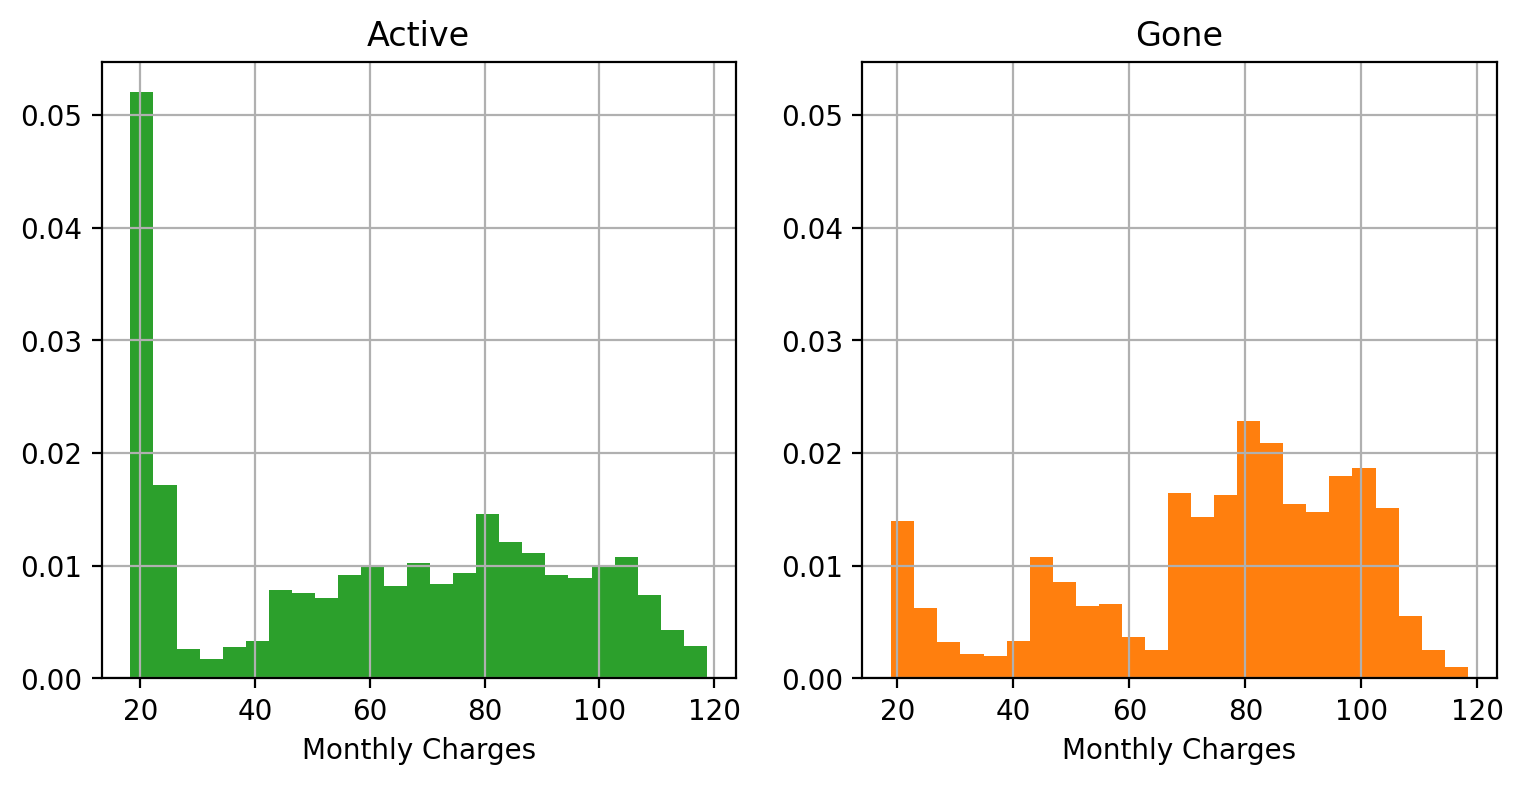

In [31]:
n_bins = 25
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(121)
ax.set_title("Active")
ax.set_xlabel("Monthly Charges")
train[train.is_lost_customer == 0].monthly_charges.hist(bins=n_bins, density=True, color="C2")
ax = fig.add_subplot(122, sharey=ax)
ax.set_title("Gone")
ax.set_xlabel("Monthly Charges")
train[train.is_lost_customer == 1].monthly_charges.hist(bins=n_bins, density=True, color="C1")
plt.show()

Видим, что оператор теряет преимущественно клиентов с ежемесячными расходами больше 70.

Сравним поведение этих групп. Построим два графика, отражающие:
- долю пользователей телефонной связи,
- долю интернет-пользователей.

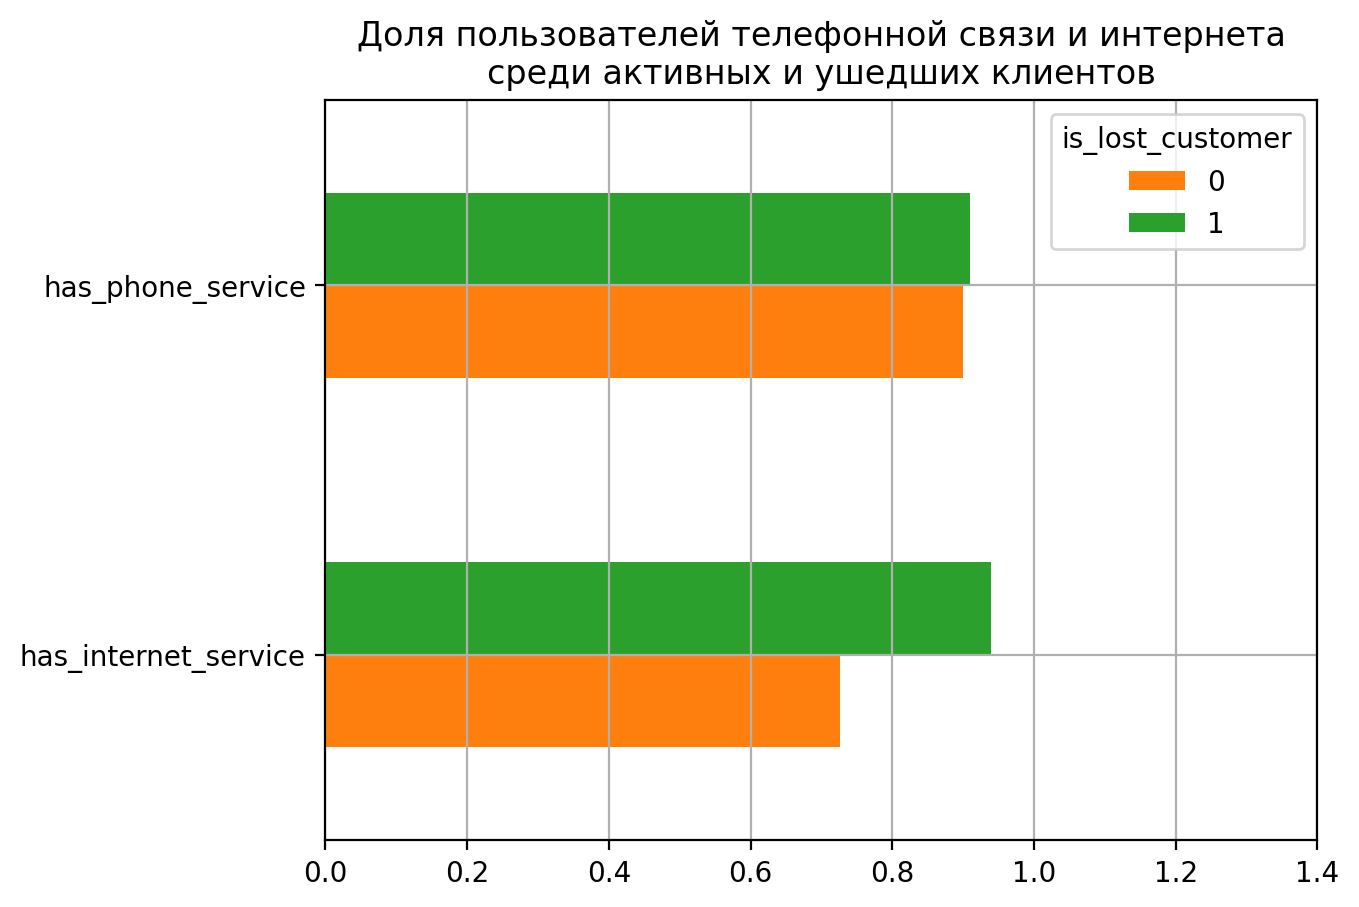

In [32]:
pd.pivot_table(train,
               index="is_lost_customer",
               values=["has_phone_service", "has_internet_service"],
              aggfunc="mean").T.plot.barh(color=["C1", "C2"], grid=True)
plt.title("Доля пользователей телефонной связи и интернета\nсреди активных и ушедших клиентов")
plt.xlim(0, 1.4) # пространство для легенды
plt.show()

Доля пользователей телефонной связью не отличается между активными и ушедшими клиентами, а доля пользователей сервисом интернета заметно выше для ушедших клиентов.

### Выводы

Мы проанализировали распределения величин ежемесячных платежей для активных и ушедших клиентов. Выяснили, что ежемесячные платежи этих групп отличаются, среди ушедших клиентов больше тех, кто платил в месяц более 70.

Сравнение поведения активных и ушедших клиентов показывает, что доля пользователей телефонной связью не отличается между активными и ушедшими клиентами, а доля пользователей сервисом интернета заметно выше для ушедших клиентов.

## Обучение моделей

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train.drop("is_lost_customer", axis=1),
    train.is_lost_customer,
    test_size=0.25,
    stratify=train.is_lost_customer,
    random_state=RANDOM_SEED)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((4225, 23), (1409, 23), (4225,), (1409,))

### Решающее дерево

In [58]:
tree_clf = DecisionTreeClassifier(max_depth=10,
                                  max_features="sqrt",
                                  random_state=RANDOM_SEED)

In [59]:
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, max_features='sqrt', random_state=20230311)

In [60]:
proba = tree_clf.predict_proba(X_valid)

In [75]:
print(
f"ROC AUC:   {roc_auc_score(y_valid, proba[:, 1]):.4f}\n"\
f"Accuracy: {tree_clf.score(X_valid, y_valid): .4f}")

ROC AUC:   0.8326
Accuracy:  0.7566


### Бустинг

In [63]:
categorical_columns = ['is_paperless_billing',
       'customer_gender', 'is_customer_senior', 'has_partner',
       'has_dependents', 'has_multiple_lines_phone', 'internet_type',
       'has_online_security', 'has_online_backup', 'has_device_protection',
       'has_tech_support', 'has_streaming_tv', 'has_streaming_movies',
       'has_phone_service', 'has_internet_service',
       'is_one_year_contract', 'is_two_year_contract', 'is_bank_payment',
       'is_card_payment', 'is_echeck_payment']

In [64]:
hist_clf = HistGradientBoostingClassifier(
    max_depth=7,
    categorical_features=categorical_columns, random_state=RANDOM_SEED)

In [65]:
hist_clf.fit(X_train, y_train)

HistGradientBoostingClassifier(categorical_features=['is_paperless_billing',
                                                     'customer_gender',
                                                     'is_customer_senior',
                                                     'has_partner',
                                                     'has_dependents',
                                                     'has_multiple_lines_phone',
                                                     'internet_type',
                                                     'has_online_security',
                                                     'has_online_backup',
                                                     'has_device_protection',
                                                     'has_tech_support',
                                                     'has_streaming_tv',
                                                     'has_streaming_movies',
                                                     'has_phone_service',
                                                     'has_internet_service',
                                                     'is_one_year_contract',
                                                     'is_two_year_contract',
                                                     'is_bank_payment',
                                                     'is_card_payment',
                                                     'is_echeck_payment'],
                               max_depth=7, random_state=20230311)

In [66]:
proba = hist_clf.predict_proba(X_valid)

In [76]:
print(
f"ROC AUC:   {roc_auc_score(y_valid, proba[:, 1]):.4f}\n"\
f"Accuracy: {hist_clf.score(X_valid, y_valid): .4f}")

ROC AUC:   0.8326
Accuracy:  0.7800


### Нейронная сеть

## Тестирование модели

1. Проведите графический анализ «Матрица ошибок». Выведите полноту и точность на график.
1. Проанализируйте важность основных факторов, влияющих на отток клиента.
1. Для одного из выявленных важных факторов проведите дополнительное исследование:
    - Покажите график зависимости фактора и целевой переменной.

## Вывод

рекомендации оператору связи